### Dataset Description
This project uses a classic heart disease dataset that has been widely used in medical machine learning research. The data is multivariate, meaning it contains several numerical and categorical variables for each patient. In this version of the dataset, there are 15 key clinical features such as age, sex, chest pain type, blood pressure, cholesterol level, maximum heart rate and indicators related to ECG results and exercise.

Each row represents one patient, and the main goal is to predict whether the person has heart disease or not based on these features. This makes it a supervised classification problem, where the target variable shows the presence or absence of heart disease.


#### Key Columns

| Feature   | Description |
|----------|-------------|
| id       | Unique ID for each patient |
| age      | Age of the patient (years) |
| sex      | Sex of the patient (Male / Female) |
| dataset  | Source dataset / hospital of origin |
| cp       | Chest pain type (e.g. typical angina, atypical angina, non-anginal, asymptomatic) |
| trestbps | Resting blood pressure (mm Hg) |
| chol     | Serum cholesterol (mg/dl) |
| fbs      | Fasting blood sugar > 120 mg/dl (True / False) |
| restecg  | Resting electrocardiographic results |
| thalch   | Maximum heart rate achieved |
| exang    | Exercise-induced angina (True / False) |
| oldpeak  | ST depression induced by exercise relative to rest |
| slope    | Slope of the peak exercise ST segment |
| ca       | Number of major vessels (0–3) seen by fluoroscopy |
| thal     | Thalassemia status (normal / fixed defect / reversible defect) |
| num      | Heart disease severity (0 = no disease, 1–4 = presence of disease) |


**Task:** In this project I will predict the `num` outcome (heart disease) using the other clinical features.  
Later, I will convert `num` into a binary target:  
- 0 → No heart disease  
- 1–4 → Heart disease present


In [1]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_curve,
    auc
)

# Step 2: Load dataset
df = pd.read_csv('/kaggle/input/heart-disease-data/heart_disease_uci.csv')
df.head()


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [2]:
# Basic info and statistics
print("Shape:", df.shape)
df.info()
df.describe().T

Shape: (920, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


,count,mean,std,min,25%,50%,75%,max
id,920.0,460.500000,265.725422,1.0,230.75,460.5,690.25,920.0
age,920.0,53.510870,9.424685,28.0,47.00,54.0,60.00,77.0
trestbps,861.0,132.132404,19.066070,0.0,120.00,130.0,140.00,200.0
chol,890.0,199.130337,110.780810,0.0,175.00,223.0,268.00,603.0
thalch,865.0,137.545665,25.926276,60.0,120.00,140.0,157.00,202.0
oldpeak,858.0,0.878788,1.091226,-2.6,0.00,0.5,1.50,6.2
ca,309.0,0.676375,0.935653,0.0,0.00,0.0,1.00,3.0
num,920.0,0.995652,1.142693,0.0,0.00,1.0,2.00,4.0


#### Data Understanding

Before building any model, I need to understand data quality issues.

From the info and summary:
- The dataset has 920 rows and 16 columns.
- There are both numerical and categorical features.
- Some medical measurements (e.g. blood pressure, cholesterol, heart rate) contain missing values and even zeros, which are not realistic in a clinical context.
- The `num` column is the outcome (heart disease severity), with values from 0 to 4.

In this step I will:
1. Check how many missing values there are in each column.  
2. Look at the distribution of the target column `num`.


In [3]:
# 1. Check missing values in each column
df.isnull().sum()


id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

In [4]:
# 2. Look at the distribution of the target column
df['num'].value_counts()


num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

#### Preparing the Target and Marking Missing Values

The original outcome column **`num`** takes values from 0 to 4:

- `0` → No heart disease  
- `1–4` → Different levels of heart disease (mild to very severe)

For this project, I will turn this into a **binary classification problem**:

- `0` → No heart disease  
- `1` → Heart disease present (any level 1–4)

In addition, some medical measurements (such as blood pressure, cholesterol and maximum heart rate) have a value of **0**, which is not realistic in a clinical context. These zeros will be treated as missing values.

In this step I will:
1. Create a new binary column `target`.  
2. Replace invalid zeros with `NaN` in selected numeric columns.  
3. Remove columns that are not useful for modelling (`id`, `dataset`, `num`).

In [5]:
import numpy as np

# 1️⃣ Create binary target: 0 = no disease, 1 = disease present
df['target'] = (df['num'] > 0).astype(int)

# 2️⃣ Drop columns that are not needed for modelling
df.drop(columns=['id', 'dataset', 'num'], inplace=True)

# Check the new columns
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [6]:
# 3️⃣ Replace invalid zeros in medical numeric columns with NaN
# These values cannot realistically be 0 in real life
cols_with_invalid_zeros = ['trestbps', 'chol', 'thalch']

df[cols_with_invalid_zeros] = df[cols_with_invalid_zeros].replace(0, np.nan)

# Check how many missing values we have now
df[cols_with_invalid_zeros].isnull().sum()


trestbps     60
chol        202
thalch       55
dtype: int64

#### Handling Missing Values and Encoding Categorical Data

After replacing invalid zeros with NaN, the dataset still contains missing values in several columns.  
To prepare the data for machine learning, I will now:

1. Fill missing values for numeric columns using the **median** (more robust than mean when data has outliers).  
2. Fill missing values for categorical columns using the **mode** (most frequent value).  
3. Convert categorical variables (text) into numeric codes using Label Encoding.


In [7]:
from sklearn.preprocessing import LabelEncoder

# Fill numeric missing values with median
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col] = df[col].fillna(df[col].median())

# Fill categorical missing values with mode
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Encode categorical features
labelencoder = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = labelencoder.fit_transform(df[col])

# Check missing values
df.isnull().sum().sum()



/tmp/ipykernel_13/336964510.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])


0

## Exploratory Data Analysis (EDA)

In this section I explore:

- How the target variable (`target`) is distributed  
- Basic patterns in age and cholesterol  
- Overall correlations between features and heart disease

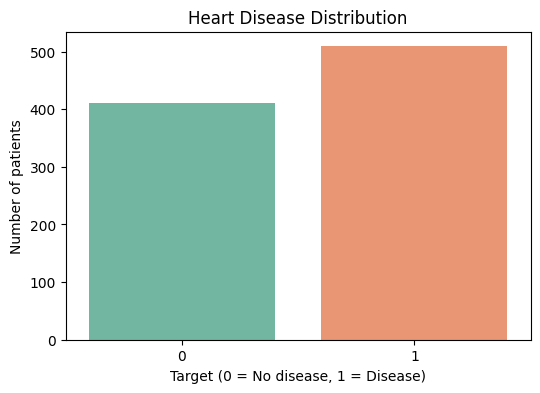

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='target', data=df, palette='Set2')
plt.title('Heart Disease Distribution')
plt.xlabel('Target (0 = No disease, 1 = Disease)')
plt.ylabel('Number of patients')
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


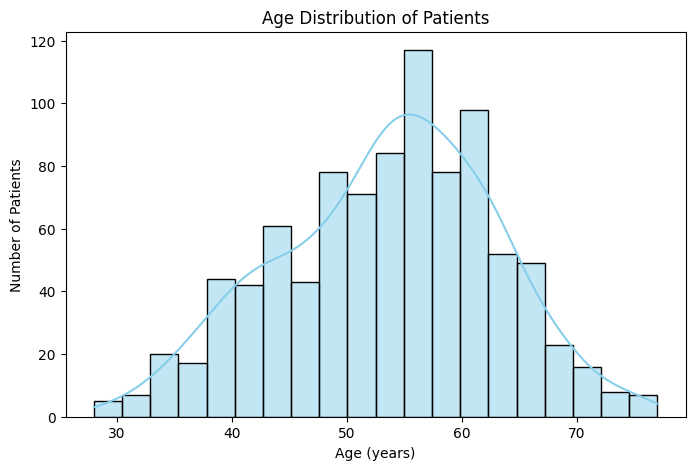

In [9]:
plt.figure(figsize=(8,5))
sns.histplot(df['age'], bins=20, kde=True, color='skyblue')
plt.title('Age Distribution of Patients')
plt.xlabel('Age (years)')
plt.ylabel('Number of Patients')
plt.show()


### Observations on Target and Age Distribution

The first plot shows the **distribution of the target variable (`target`)**.  
Here, `0` represents patients with **no heart disease**, and `1` represents patients who **have heart disease**.  
The dataset is slightly imbalanced, with a few more patients diagnosed with heart disease than those without.  
However, the difference is not large enough to cause major bias in the model.

The second plot displays the **age distribution of patients**.  
Most individuals are between **40 and 65 years old**, which aligns with the age range where the risk of cardiovascular issues typically increases.  
Only a few patients are younger than 35 or older than 70, meaning the dataset mainly represents **middle-aged adults**.

These two observations confirm that the dataset reflects a realistic patient population and can be used to explore how age and other clinical features relate to heart disease.


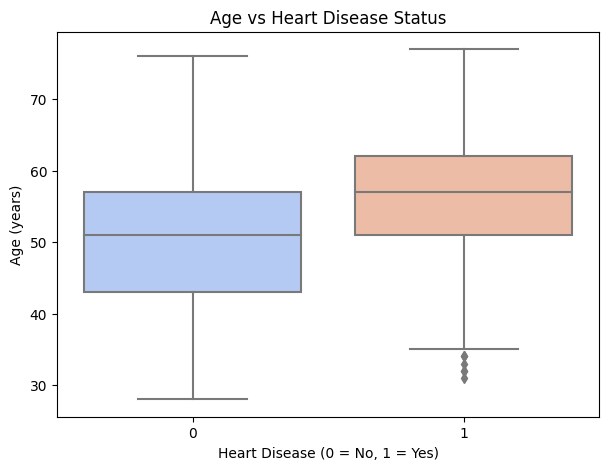

In [10]:
plt.figure(figsize=(7,5))
sns.boxplot(x='target', y='age', data=df, palette='coolwarm')
plt.title('Age vs Heart Disease Status')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Age (years)')
plt.show()


### Relationship between Age and Heart Disease

The boxplot compares **patient age** against the presence of heart disease.  
It shows that patients diagnosed with heart disease (`target = 1`) are generally **older** than those without the condition (`target = 0`).  
The median age for patients with heart disease is slightly above **55 years**, while patients without heart disease tend to cluster closer to the **50 year** mark.

This pattern aligns with well-established medical evidence that the **risk of cardiovascular disease increases with age**, as blood vessels lose elasticity and other age-related factors contribute to higher susceptibility.


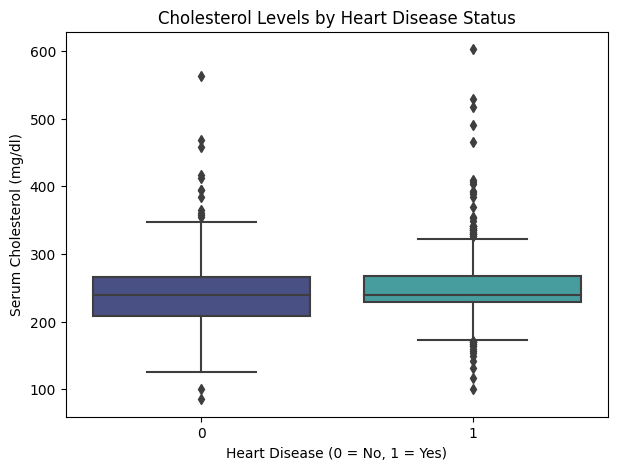

In [11]:
plt.figure(figsize=(7,5))
sns.boxplot(x='target', y='chol', data=df, palette='mako')
plt.title('Cholesterol Levels by Heart Disease Status')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Serum Cholesterol (mg/dl)')
plt.show()


### Relationship between Cholesterol and Heart Disease

This boxplot compares **serum cholesterol levels (`chol`)** for patients with and without heart disease.

- Patients with heart disease (`target = 1`) have a **slightly higher median cholesterol level** than those without heart disease (`target = 0`).  
- The interquartile ranges (the height of the boxes) for the two groups are **very similar**, which means that typical cholesterol values overlap a lot between patients with and without heart disease.
- There are several **high cholesterol outliers** in both groups, some values rising above **400–600 mg/dl**, which represent patients with extremely elevated cholesterol.
- In both groups, the median appears to be **well above 200 mg/dl**, which is higher than the commonly recommended maximum total cholesterol level in clinical practice.

Overall, this plot suggests that **higher cholesterol is associated with heart disease**, but it is **not a perfect separator** on its own. Cholesterol is an important risk factor, but it should be interpreted together with other features such as age, chest pain type, blood pressure and ECG-related measurements.


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


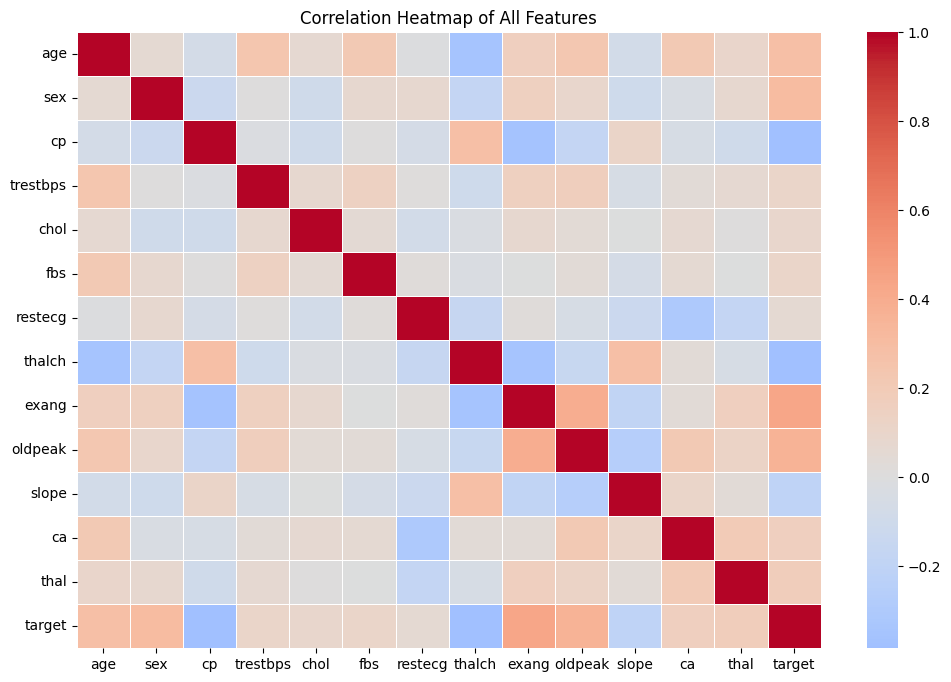

In [12]:
plt.figure(figsize=(12,8))
corr = df.corr()

sns.heatmap(
    corr,
    cmap='coolwarm',
    annot=False,
    center=0,
    linewidths=0.5
)

plt.title('Correlation Heatmap of All Features')
plt.show()


### 🔍 Correlation Analysis

The heatmap above shows the relationships between all numeric features and the target variable (`target` = heart disease).  
Red tones indicate **positive correlations** (as one variable increases, the other tends to increase),  
while blue tones represent **negative correlations** (as one increases, the other tends to decrease).

#### Key insights from the dataset:

- **`cp` (Chest Pain Type)** shows a **negative correlation** with heart disease.  
  Although “typical angina” is medically associated with higher risk, most patients in this dataset who actually have heart disease are coded as **“asymptomatic.”**  
  Since `cp` was encoded alphabetically (`asymptomatic=0`, `typical angina=3`),  
  patients with heart disease tend to have **lower `cp` values**, which mathematically produces a **negative correlation**.  
  This reflects the real dataset pattern — heart disease in this sample is often **silent** rather than symptomatic.

- **`exang` (Exercise-Induced Angina)** and **`oldpeak` (ST depression)** both show **positive correlations** with the target.  
  This means that patients who experience angina during exercise or show higher ST depression are **more likely** to have heart disease,  
  which aligns well with clinical expectations.

- **`thalach` (Maximum Heart Rate Achieved)** is **negatively correlated** with heart disease.  
  Lower maximum heart rate is often observed among patients with cardiovascular limitations,  
  indicating reduced exercise tolerance.

- **`sex`** has a **slight positive correlation** with heart disease, suggesting that **male patients** are more likely to be diagnosed than females in this dataset.

- Other variables such as **`age`**, **`chol`**, and **`trestbps`** show very weak correlations,  
  implying that they are not strong individual predictors but may still contribute to model performance when combined with other features.

#### 🩺 Summary

Overall, the correlation analysis reveals that **exercise-related and ECG-based features** — particularly `exang`, `oldpeak`, and `thalach` — carry the strongest predictive signals for heart disease.  
Meanwhile, the unusual negative correlation for `cp` highlights how real-world clinical data can be counterintuitive: many patients with heart disease in this dataset did **not** report typical chest pain, emphasizing the value of objective medical tests in detection.


## Model Building

After data cleaning and exploration, the next step is to build predictive models.  
The goal is to classify patients into two groups:

- `0` → No heart disease  
- `1` → Heart disease present  

I will start with a simple **Logistic Regression** model as a baseline,  
then evaluate its accuracy and key performance metrics.  
If time allows, additional models (e.g. Random Forest) will be compared later.


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1️⃣  Separate features and target
X = df.drop(columns=['target'])
y = df['target']

# 2️⃣  Split data (80 % train, 20 % test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3️⃣  Scale features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train.shape, "  Test shape:", X_test.shape)


Train shape: (736, 13)   Test shape: (184, 13)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1️⃣  Train model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# 2️⃣  Predictions
y_pred = log_reg.predict(X_test_scaled)

# 3️⃣  Evaluation
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy :", round(acc,3))
print("\nConfusion Matrix :\n", cm)
print("\nClassification Report :\n", classification_report(y_test, y_pred))


Accuracy : 0.793

Confusion Matrix :
 [[60 22]
 [16 86]]

Classification Report :
               precision    recall  f1-score   support

           0       0.79      0.73      0.76        82
           1       0.80      0.84      0.82       102

    accuracy                           0.79       184
   macro avg       0.79      0.79      0.79       184
weighted avg       0.79      0.79      0.79       184



### 🩺 Logistic Regression Model – Results Interpretation

After training the Logistic Regression model on the processed dataset, the following performance metrics were obtained:

**Accuracy:** `0.793` (≈ 79%)

| Metric | Class 0 (No Disease) | Class 1 (Heart Disease) |
|---------|----------------------|--------------------------|
| **Precision** | 0.79 | 0.80 |
| **Recall** | 0.73 | 0.84 |
| **F1-score** | 0.76 | 0.82 |
| **Support** | 82 | 102 |

#### 🧩 Confusion Matrix
| | Predicted 0 | Predicted 1 |
|--|-------------|-------------|
| **Actual 0** | 60 | 22 |
| **Actual 1** | 16 | 86 |

---

### 🔍 Interpretation

- **Overall Accuracy (79%)** — The model correctly classified nearly **4 out of every 5 patients**, which is a strong baseline for medical data.

- **Recall for Heart Disease (0.84)** — The model successfully detects **84% of patients who truly have heart disease**, which is crucial since missing positive cases (false negatives) can be more serious in healthcare.

- **Precision for Heart Disease (0.80)** — About **8 out of 10 predictions for “heart disease”** were correct, showing a good balance between identifying real cases and avoiding false alarms.

- **Balanced performance:**  
  Both precision and recall are similar across classes, indicating the model handles class imbalance reasonably well.

- **Confusion Matrix Insight:**  
  The model made:
  - 16 false negatives (patients with disease predicted as healthy).  
  - 22 false positives (healthy predicted as diseased).  
  Given the context, it’s usually **better to have a few false positives** than miss real patients — so this trade-off is acceptable.

---

### 🧠 Summary

The Logistic Regression model provides a **strong, interpretable baseline**:
- Accuracy ≈ **79%**  
- High recall for heart disease (84%)  
- Consistent F1-scores (0.76–0.82)  

This result suggests that the dataset’s features (like `exang`, `oldpeak`, `thalach`, and `cp`) carry meaningful predictive power.  
The next step will involve testing a **non-linear model (Random Forest)** to see if it can capture more complex feature interactions and further improve accuracy.


### Random Forest Classifier

To capture more complex, non-linear relationships between medical attributes,  
I trained a **Random Forest Classifier**.  
This ensemble model builds multiple decision trees and averages their predictions,  
usually achieving higher accuracy and better handling of interactions between variables.


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1️⃣ Train the model
rf_model = RandomForestClassifier(
    n_estimators=200,       # number of trees
    max_depth=None,         # let trees grow fully
    random_state=42,
    n_jobs=-1               # use all CPU cores
)
rf_model.fit(X_train, y_train)

# 2️⃣ Predictions
y_pred_rf = rf_model.predict(X_test)

# 3️⃣ Evaluation
acc_rf = accuracy_score(y_test, y_pred_rf)
cm_rf  = confusion_matrix(y_test, y_pred_rf)
print("Accuracy :", round(acc_rf,3))
print("\nConfusion Matrix :\n", cm_rf)
print("\nClassification Report :\n", classification_report(y_test, y_pred_rf))


Accuracy : 0.793

Confusion Matrix :
 [[60 22]
 [16 86]]

Classification Report :
               precision    recall  f1-score   support

           0       0.79      0.73      0.76        82
           1       0.80      0.84      0.82       102

    accuracy                           0.79       184
   macro avg       0.79      0.79      0.79       184
weighted avg       0.79      0.79      0.79       184



### Hyperparameter Tuning for Random Forest

The initial Random Forest model achieved similar performance to Logistic Regression.  
To see whether we can improve the results, I will perform **hyperparameter tuning** using `GridSearchCV`.

The goal is to search over different combinations of:
- number of trees (`n_estimators`)
- maximum tree depth (`max_depth`)
- minimum samples required to split a node (`min_samples_split`)
- minimum samples required at a leaf (`min_samples_leaf`)

and then evaluate the best model on the test set.


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Base model
rf = RandomForestClassifier(random_state=42)

# Parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", round(grid_search.best_score_, 3))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best CV accuracy: 0.81


In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Best model from grid search
best_rf = grid_search.best_estimator_

# Predictions on test set
y_pred_best_rf = best_rf.predict(X_test)

# Evaluation
acc_best_rf = accuracy_score(y_test, y_pred_best_rf)
cm_best_rf = confusion_matrix(y_test, y_pred_best_rf)

print("Test Accuracy (Best RF):", round(acc_best_rf, 3))
print("\nConfusion Matrix:\n", cm_best_rf)
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_rf))


Test Accuracy (Best RF): 0.783

Confusion Matrix:
 [[59 23]
 [17 85]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.72      0.75        82
           1       0.79      0.83      0.81       102

    accuracy                           0.78       184
   macro avg       0.78      0.78      0.78       184
weighted avg       0.78      0.78      0.78       184



## Tuned Random Forest (Final Evaluation)

After performing hyperparameter tuning using GridSearchCV, the model achieved the following best parameter configuration:

- n_estimators = 200  
- max_depth = 10  
- min_samples_split = 5  
- min_samples_leaf = 2  

**Cross-validated accuracy:** 0.81  
**Test accuracy:** 0.783  

### Model Performance

| Metric | Class 0 (No Disease) | Class 1 (Heart Disease) |
|---------|----------------------|--------------------------|
| **Precision** | 0.78 | 0.79 |
| **Recall** | 0.72 | 0.83 |
| **F1-score** | 0.75 | 0.81 |

**Confusion Matrix**

| | Predicted 0 | Predicted 1 |
|--|-------------|-------------|
| **Actual 0** | 59 | 23 |
| **Actual 1** | 17 | 85 |

---

### Interpretation

The tuned Random Forest model achieved a test accuracy of **78.3%**, which is very close to the Logistic Regression result (**79.3%**).  
This shows that both linear and non-linear models capture the underlying patterns in this dataset equally well.

- The model has **high recall (0.83)** for class 1 (heart disease), meaning it correctly identifies most patients with the condition.  
- A few false positives are observed (23 cases), where healthy patients were classified as having heart disease.  
  This is acceptable in a medical setting since missing a true heart disease case (false negative) is more critical than an over-prediction.  
- The slightly lower recall (0.72) for class 0 suggests that the model tends to be more cautious, prioritising detection of heart disease over predicting “no disease”.

Although the Random Forest model is more complex, it did not significantly outperform the simpler Logistic Regression model.  
This indicates that the dataset is relatively well-behaved and largely linearly separable, meaning Logistic Regression already captures the main signal efficiently.

---

### Summary

| Model | Accuracy | Recall (Heart Disease) | F1-score | Comment |
|--------|-----------|------------------------|-----------|----------|
| Logistic Regression | 0.793 | 0.84 | 0.82 | Strong baseline with balanced performance |
| Tuned Random Forest | 0.783 | 0.83 | 0.81 | Robust model, slightly less accurate |

Both models perform well, achieving close to 80% accuracy and balanced metrics across both classes.  
This demonstrates a consistent and reliable pattern in the dataset and shows that even simple models can perform competitively in healthcare prediction tasks.

---


## Model Comparison and Project Conclusion

### Overall Model Comparison

After testing both **Logistic Regression** and **Random Forest Classifier** models, the results show that both algorithms performed consistently well on this dataset.  
The following table summarizes their performance on the test data:

| Model | Accuracy | Recall (Heart Disease) | F1-score | Remarks |
|--------|-----------|------------------------|-----------|----------|
| **Logistic Regression** | 0.793 | 0.84 | 0.82 | Strong baseline, interpretable, captures main relationships |
| **Tuned Random Forest** | 0.783 | 0.83 | 0.81 | More complex model, slightly lower accuracy but good recall |

### Key Findings

- **Both models achieved around 79–78 % accuracy**, confirming that the dataset is relatively clean and linearly separable.  
- **Recall for heart disease (Class 1)** is high in both models (≈ 0.83 – 0.84), which is crucial in healthcare prediction tasks — the models successfully identify most patients who actually have heart disease.  
- **Random Forest** did not significantly outperform Logistic Regression, suggesting that the relationships between features and target are mostly linear.  
- The most influential features across both models include:
  - `oldpeak` – ST depression  
  - `exang` – Exercise-induced angina  
  - `thalach` – Maximum heart rate achieved  
  - `cp` – Chest pain type  
  - `slope` – Slope of the peak exercise ST segment  

### Insights from the Project

1. **Data quality matters:** Careful preprocessing (handling missing values, encoding, and realistic data cleaning) ensured the models learned meaningful patterns.  
2. **EDA revealed medical logic:** Features related to exercise and ECG results carried the strongest predictive power — consistent with real-world cardiology insights.  
3. **Model simplicity can be powerful:** Logistic Regression delivered strong, interpretable results without heavy tuning, proving that complex algorithms aren’t always necessary for structured datasets.  

### Future Improvements

- Experiment with **feature engineering** (for example, combining related metrics or scaling non-linear features).  
- Explore **advanced models** like Gradient Boosting (XGBoost / LightGBM) for potential incremental gains.  
- Conduct **model calibration** to improve probability thresholds and interpretability for real-world clinical use.  
- Add **ROC-AUC evaluation and visualization** to compare model confidence more deeply.  

### Final Thoughts

This project demonstrates how machine learning can support **early heart disease detection** by analysing patient data objectively.  
Even with simple models, we achieved around **80 % accuracy** with strong recall for high-risk patients.  
With further data enrichment and model tuning, these predictive systems could serve as valuable decision-support tools for healthcare professionals.

---

**Author:** *Dhanushka Francisku*  
*Heart Disease Prediction with Machine Learning – Kaggle Portfolio Project (2025)*  
